### Mechanistic Free Energy Principle Model of General Suicidal Thoughts

<img src="fig/Fig1.png" width="800">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helper import create_likelihood_matrix, get_prior, inference, plot_sim, step, collect, impulse

sizes, sizei, sized, sizep = [50, 50, 50, 8]
decays1, decays2, decayi1, decayi2, decayd1, decayd2, decayp1, decayp2 = [2, 1, 2, 0.8, 2, 0.5, 2, 1]
w_si, w_sd, w_sp, w_id, w_ip, w_dp = [0.5, 0.1, 0.9, 0.2, 0.8, 0.7]

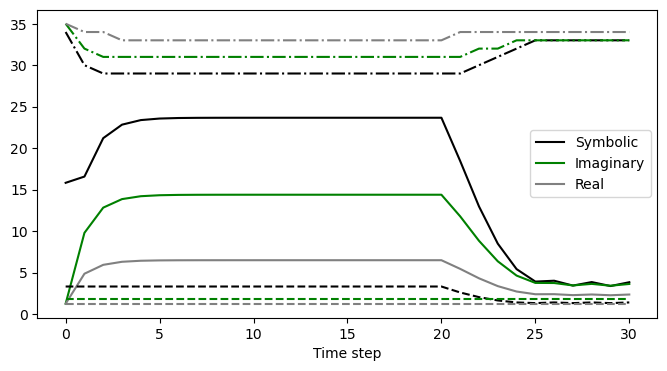

In [2]:
likelihood_s = create_likelihood_matrix(sizes, decays1)
prior_s = get_prior(25, sizes, decays2)

likelihood_i = create_likelihood_matrix(sizei, decayi1)
prior_i = get_prior(25, sizei, decayi2)

likelihood_d = create_likelihood_matrix(sized, decayd1)
prior_d = get_prior(25, sized, decayd2)

obs_s, obs_i, obs_d = [20,25, 25]

Fss_history, Fii_history, Fdd_history = [], [], []
Fs_min_history, Fi_min_history, Fd_min_history = [], [], []
qss_history, qsi_history, qsd_history = [], [], []

qss, Fs = inference(likelihood_s, prior_s, obs_s)
Fss = Fs[obs_s]
Fss_history.append(Fss)
Fs_min = Fs[Fs.argmin()]
Fs_min_history.append(Fs_min)
qss_history.append(qss.argmax())

qsi, Fi = inference(likelihood_i, prior_i, obs_i)
qsi_history.append(qsi.argmax())
Fii = Fi[obs_i]
Fii_history.append(Fii)
Fi_min = Fi[Fi.argmin()]
Fi_min_history.append(Fi_min)

qsd, Fd = inference(likelihood_d, prior_d, obs_d)
qsd_history.append(qsd.argmax())
Fdd = Fd[obs_d]
Fdd_history.append(Fdd)
Fd_min = Fd[Fd.argmin()]
Fd_min_history.append(Fd_min)


for _ in range(20):
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)

for _ in range(10):
    if obs_s < 26:
        obs_s += 1
    else:
        obs_s =25
        
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    
plot_sim(Fi_min_history,qss_history,qsi_history,qsd_history,Fss_history,Fii_history,Fdd_history,Fs_min_history,Fd_min_history)


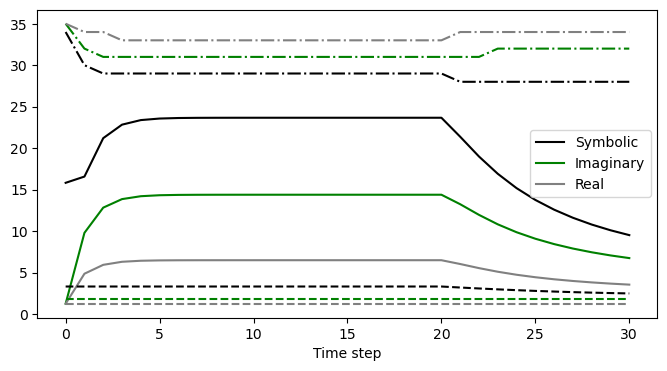

In [3]:
likelihood_s = create_likelihood_matrix(sizes, decays1)
prior_s = get_prior(25, sizes, decays2)
decayss = decays2

likelihood_i = create_likelihood_matrix(sizei, decayi1)
prior_i = get_prior(25, sizei, decayi2)

likelihood_d = create_likelihood_matrix(sized, decayd1)
prior_d = get_prior(25, sized, decayd2)

obs_s, obs_i, obs_d = [20,25, 25]

Fss_history, Fii_history, Fdd_history = [], [], []
Fs_min_history, Fi_min_history, Fd_min_history = [], [], []
qss_history, qsi_history, qsd_history = [], [], []

qss, Fs = inference(likelihood_s, prior_s, obs_s)
Fss = Fs[obs_s]
Fss_history.append(Fss)
Fs_min = Fs[Fs.argmin()]
Fs_min_history.append(Fs_min)
qss_history.append(qss.argmax())

qsi, Fi = inference(likelihood_i, prior_i, obs_i)
qsi_history.append(qsi.argmax())
Fii = Fi[obs_i]
Fii_history.append(Fii)
Fi_min = Fi[Fi.argmin()]
Fi_min_history.append(Fi_min)

qsd, Fd = inference(likelihood_d, prior_d, obs_d)
qsd_history.append(qsd.argmax())
Fdd = Fd[obs_d]
Fdd_history.append(Fdd)
Fd_min = Fd[Fd.argmin()]
Fd_min_history.append(Fd_min)


for _ in range(20):
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)

for _ in range(10):
    
    decayss += 0.1
    prior_ss = get_prior(25, sizes, decayss)
        
    qss, Fs, qsss, Fss = step(likelihood_s, prior_ss, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    
plot_sim(Fi_min_history,qss_history,qsi_history,qsd_history,Fss_history,Fii_history,Fdd_history,Fs_min_history,Fd_min_history)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


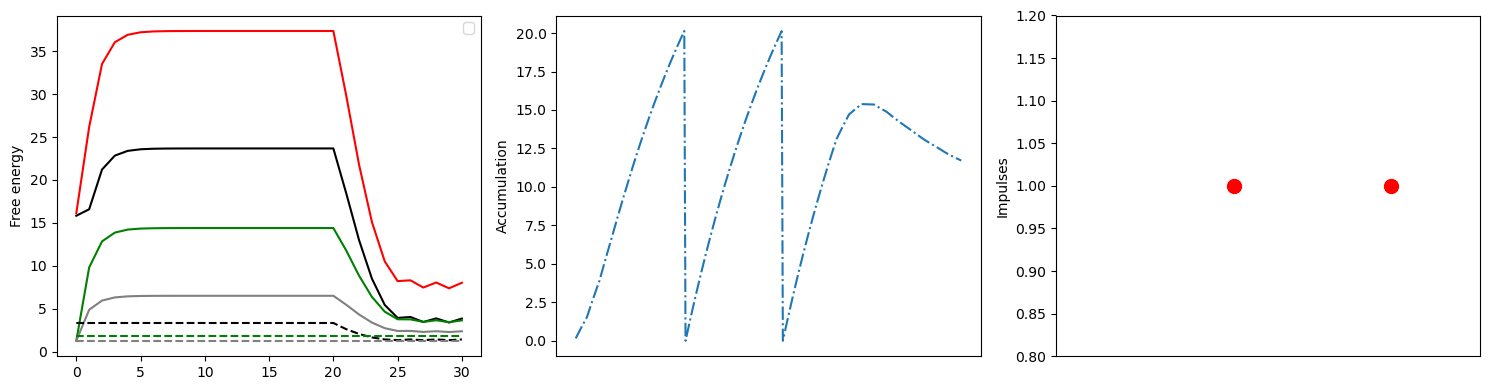

In [5]:
likelihood_s, likelihood_i, likelihood_d = create_likelihood_matrix(sizes, decays1), create_likelihood_matrix(sizei, decayi1), create_likelihood_matrix(sized, decayd1)
prior_s, prior_i, prior_d = get_prior(25, sizes, decays2), get_prior(25, sizei, decayi2), get_prior(25, sized, decayd2)
obs_s, obs_i, obs_d = [20,25, 25]
dt, tau, el, theta, t_step = 0.1, 10, 0, 20, 0
Fss_history, Fii_history, Fdd_history, Fp_history = [], [], [], []
Fs_min_history, Fi_min_history, Fd_min_history = [], [], []
qss_history, qsi_history, qsd_history = [], [], []
v_rec, t_rec, s_rec = np.array([]), np.array([]), np.array([])

qss, Fs = inference(likelihood_s, prior_s, obs_s)
Fss = Fs[obs_s]
Fss_history.append(Fss)
Fs_min = Fs[Fs.argmin()]
Fs_min_history.append(Fs_min)
qss_history.append(qss.argmax())

qsi, Fi = inference(likelihood_i, prior_i, obs_i)
qsi_history.append(qsi.argmax())
Fii = Fi[obs_i]
Fii_history.append(Fii)
Fi_min = Fi[Fi.argmin()]
Fi_min_history.append(Fi_min)

qsd, Fd = inference(likelihood_d, prior_d, obs_d)
qsd_history.append(qsd.argmax())
Fdd = Fd[obs_d]
Fdd_history.append(Fdd)
Fd_min = Fd[Fd.argmin()]
Fd_min_history.append(Fd_min)

Fp = collect(Fss, Fii, Fdd, w_sp, w_ip, w_dp)
Fp_history.append(Fp)

v = el
for t in range (int(1/dt)):
    s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)

for _ in range(20):
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    Fp = collect(Fss, Fii, Fdd, w_sp, w_ip, w_dp)
    Fp_history.append(Fp)

    for t in range (int(1/dt)):
        s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)

for _ in range(10):
    if obs_s < 26:
        obs_s += 1
    else:
        obs_s =25
        
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    Fp = collect(Fss, Fii, Fdd, w_sp, w_ip, w_dp)
    Fp_history.append(Fp)
    for t in range (int(1/dt)):
        s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)
    
Fi_min_history1 = [x + 0.6 for x in Fi_min_history]
# Create a figure with horizontal subplots
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 3)  # 1 row, 3 columns

# First subplot
ax1 = plt.subplot(gs[2])
ax1.plot(s_rec, '.', markersize=20, color='red')
ax1.axis([0, 210, 0.8, 1.2])  # Adjust the x-axis limit appropriately
ax1.set_xticks([])
ax1.set_ylabel("Impulses")

# Second subplot
ax2 = plt.subplot(gs[1])
ax2.plot(v_rec, linestyle='-.')
ax2.set_xticks([])
ax2.set_ylabel("Accumulation")

# Third subplot
ax3 = plt.subplot(gs[0])
ax3.plot(Fss_history, linestyle='-', color='black')
ax3.plot(Fii_history, linestyle='-', color='green')
ax3.plot(Fdd_history, linestyle='-', color='gray')
ax3.plot(Fp_history, linestyle='-', color='red')
ax3.plot(Fs_min_history, linestyle='--', color='black')
ax3.plot(Fi_min_history1, linestyle='--', color='green')
ax3.plot(Fd_min_history, linestyle='--', color='gray')
ax3.legend()
ax3.set_ylabel('Free energy')

# Layout adjustment to prevent overlapping
plt.tight_layout()
plt.show()